### Group 92 Project Proposal
- Members: Alan, Bowen, Jia Yi, Kiki

# Predicting Heart Disease with Patient Health Information

## Introduction

Can we use the health report information to predict whether a patient has heart disease?

Heart disease is defined as the buildup of plaque in the heart's arteries that could lead to a heart attack/failure, which leads to death in many cases.

As the second leading cause of death in Canada, about 1 in 12 Canadian adults aged 20 and older live with a diagnosed heart disease, and the death rate of a heart disease is 2.9 times higher for them versus those without. However, early detection and management can help keep this illness under control. Hence, this project aims to build a classification model that can predict and diagnose whether a patient has a heart disease so that early intervention can take place to increase chances of rehabilitation.

The dataset chosen dates back to 1988 and consists of 4 databases from Cleveland, Hungary, Switzerland, and Long Beach V. The "target" field refers to the presence of heart disease in the patient. The integer valued ‘0’ means there is no disease, while the integer valued ‘1’ shows presence of heart disease.

## Methods & Results

In [1]:
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 10)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

### Reading and Wrangling Data

#### The heart dataset has the following columns in the following order:
- Age - in years
- Sex -  (1= male; 0=female)
- Chest Pain Type - (0= typical angina; 1= atypical angina;  2= non-anginal pain; 3= asymptomatic
- Resting Blood Pressure - resting blood pressure (in mm mercury on first visit to hospital)
- Serum Cholestoral - in mg/dl
- Fasting Blood Sugar - (1= greater or equal to than 120 mg/dl; 0= less than 120 mg/dl
- Resting Electrocardiographic Results - (0 = normal; 1= having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV); 2= showing probable or definite left ventricular hypertrophy by Estes' criteria)
- Maximum Heart Rate Achieved - Maximum heart rate achieved in beats per minute
- Exercise Induced Angina - (1= yes; 0=no)
- Oldpeak - ST depression induced by exercise relative to rest
- Slope - (0= upsloping; 1= flat; 2= downsloping)
- Number of Major Vessels 
- Thal -  (3 = normal; 6 = fixed defect; 7 = reversable defect)
- Target - (0= undiagnosed; 1= diagnosed)

In [4]:
#read data
heart <- read_csv("https://raw.githubusercontent.com/bowencu/dsci100groupproject/main/heart.csv")

#clean and wrangle data
heart <- heart |>
    mutate(target = as_factor(target)) |>
    select(age, thalach, target)
heart

#split the data
heart_split <- initial_split(heart, prop = 0.75, strata = target)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

Rows: 1025 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,thalach,target
<dbl>,<dbl>,<fct>
52,168,0
53,155,0
70,125,0
61,161,0
62,106,0
⋮,⋮,⋮
59,164,1
60,141,0
47,118,0


In [3]:
#data summarized in table, number of observations in each class of target
#0 meaning no heart disease, 1 meaning heart disease
summarize_heart <- heart_train |>
    group_by(target) |>
    summarize(n = n())
summarize_heart

target,n
<fct>,<int>
0,374
1,394


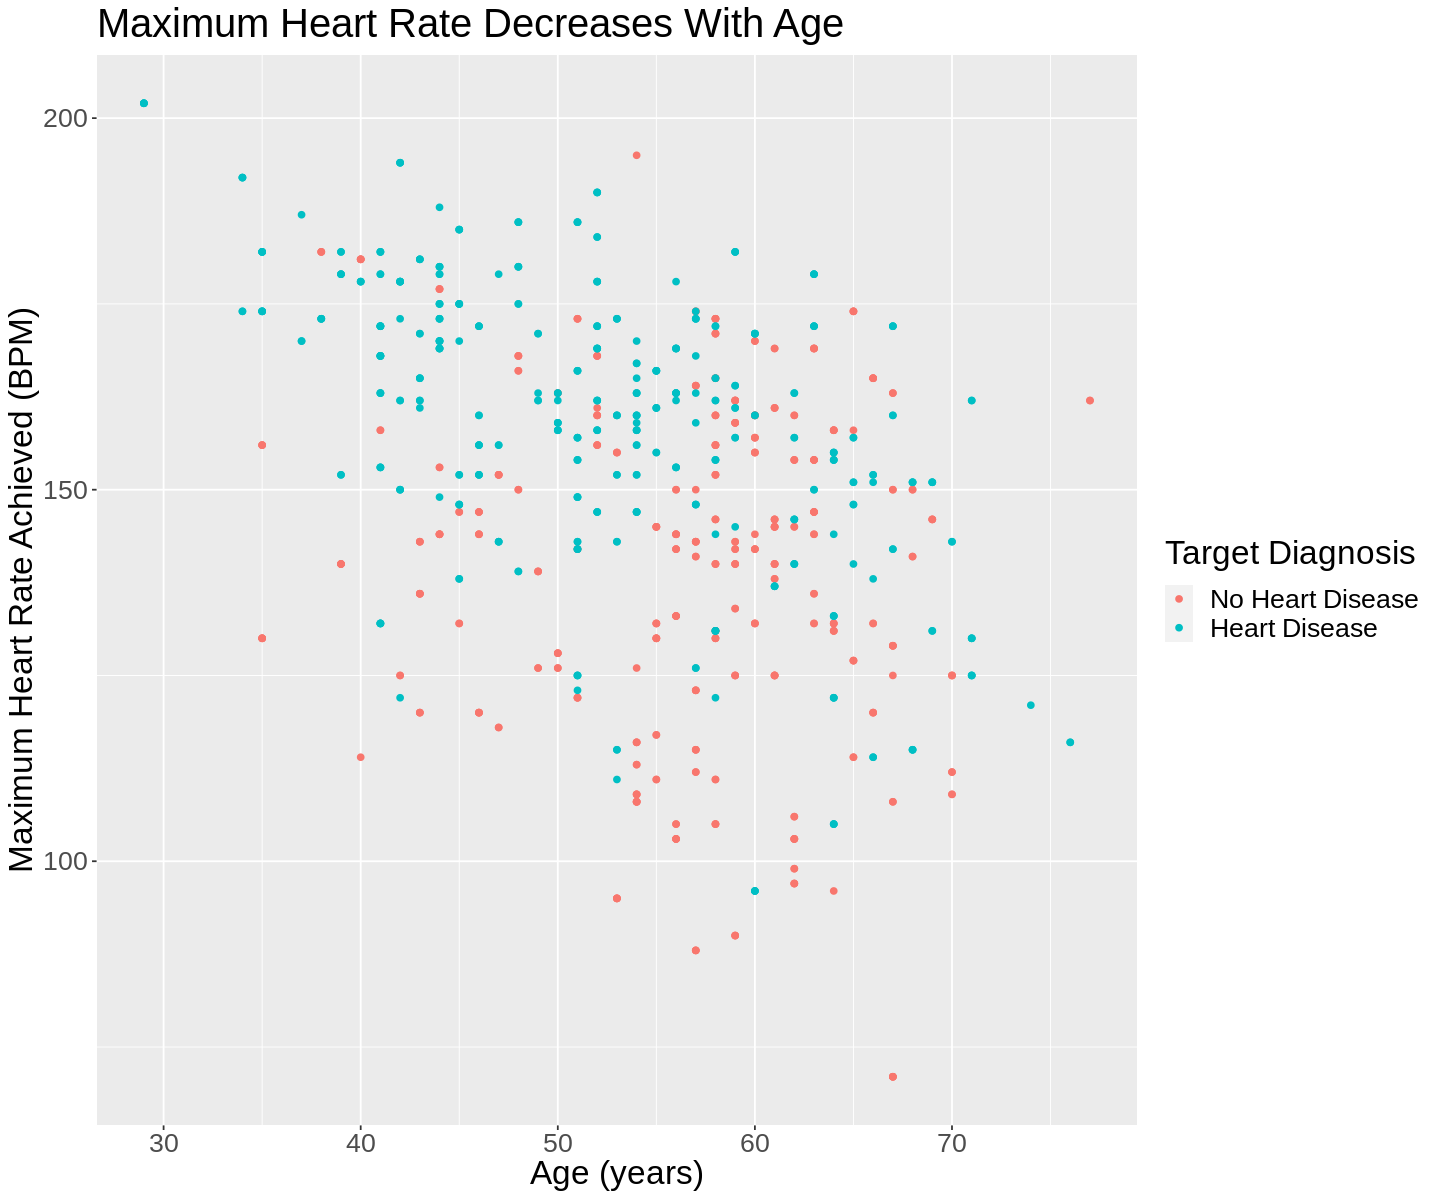

In [4]:
#visualize the data
#scatter plot of maximum heart rate against age, colour points by target diagnosis
options(repr.plot.width = 12, repr.plot.height = 10)

visualize_heart <- heart_train |>
    ggplot(aes(x = age, y = thalach, colour = target)) +
        geom_point() +
        labs(x = "Age (years)",
             y = "Maximum Heart Rate Achieved (BPM)",
             colour = "Target Diagnosis",
             title = "Maximum Heart Rate Decreases With Age") +
        scale_colour_discrete(labels = c("No Heart Disease", "Heart Disease")) +
        theme(text = element_text(size = 20))
visualize_heart

### Methods

- Split the data into testing and training sets: 75% training and 25% testing
- Create a recipe, using columns “thalach” and “age” as predictors. Scale and centre predictors
- Create a validation set to determine the number of k-nearest-neighbors that yield the most accurate predictions. Perform a 5-fold cross validation on the training data
- Create k-nearest-neighbor model specification. Set ‘weight_func’ argument to rectangular to obtain the straight-line distance. Set ‘neighbors’ argument to tune(). Set engine to ‘kknn’ and set mode to ‘classification’ as we are predicting categorical variables
- Create a workflow combining the training data recipe and model. Use tune_grid() function and set the ‘grid’ argument equal to 10 K values. Use collect_metrics() to aggregate the mean and standard error
- Filter for accuracies from .metric column
- Create a visualisation to determine the best K value. Plot neighbors against accuracy estimate (mean).
- Build a model using the K value that provides the highest accuracy. Pass model and recipe through the fit() function.
- Use this final model to predict on the test dataset. Use predict() function and bind columns to the test dataset. 
- Report the accuracy of the prediction; collect metrics and filter .metric column for accuracy.
- Report the confusion matrix
- Create a new observation in a tibble. Pass knn model and new observation through predict() function to determine if the ‘new patient’ has heart disease

## Discussion

### Expected outcomes and significance

Heart disease patients need an immediate diagnosis.Doctors identify it based on results of clinical testing and prior experience treating patients presented with comparable symptoms. Our model will attempt to simulate a similar role, where age and maximum BPM are used to predict whether someone has heart disease. Furthermore, we expect to use a testing set to confirm the accuracy of our model. However, our current graph observes that there is a mix of points around the top middle area of the graph. We predict our classifier to have a lower accuracy for certain ranges of the data, which will cause serious health risks when misdiagnosing patients.

Limitations: Despite our data set having a handful of predictors that are numerical, we only use 2 that we believe are the biggest predictors. The investigation can be potentially extended by testing multiple predictors to find which one has the biggest impact. This would justify the selection of our 2 predictors from a statistical perspective. Furthermore, there is the potential to use 3 predictors at the same time to make a 3D model. However this would be hard to implement with our group’s current skills.

## References

https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset